In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from scipy.stats import multivariate_normal

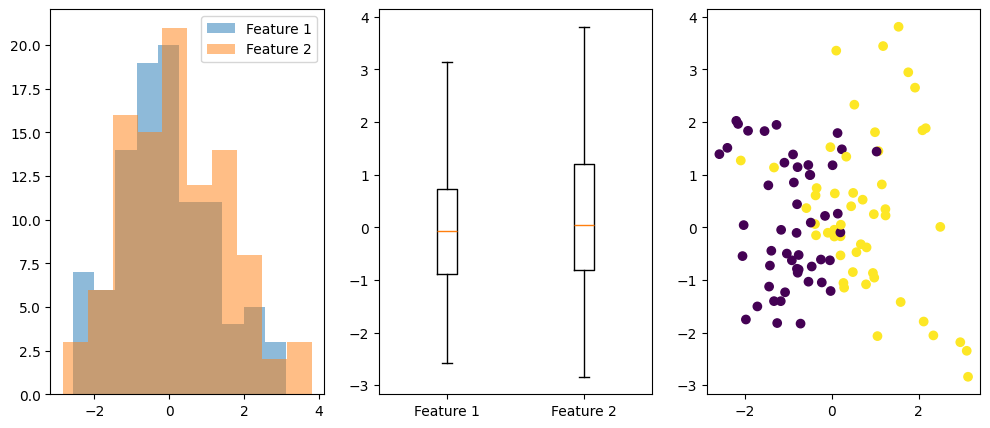

In [2]:
X, y = make_classification(n_features=2, n_informative=2, n_redundant=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.hist(X[:, 0], alpha=0.5, label='Feature 1')
ax1.hist(X[:, 1], alpha=0.5, label='Feature 2')
ax1.legend()
ax2.boxplot([X[:, 0], X[:, 1]], labels=['Feature 1', 'Feature 2'])
ax3.scatter(X[:, 0], X[:, 1], c=y);

In [44]:
def estimate_params(X, y):
    params = {}
    for cls in np.unique(y):
        cls_X = X[y == cls]
        params[cls] = {
            'mean': cls_X.mean(axis=0),
            'cov': np.cov(cls_X, rowvar=False)
        }
    return params

class BayesClassifier:
    def __init__(self, cov='no_assumptions'):
        self.cov = cov
        self.params = {}
    
    def fit(self, X, y):
        self.params = estimate_params(X, y)
        pooled_cov = np.mean([self.params[cls]['cov'] for cls in self.params], axis=0)

        if self.cov == 'shared_scalar':
            avg_var = np.mean(np.diag(pooled_cov))
            common_cov = np.eye(X.shape[1]) * avg_var
            for cls in self.params:
                self.params[cls]['cov'] = common_cov
                
        elif self.cov == 'shared_diag':
            common_cov = np.diag(np.mean(np.array([np.diag(self.params[cls]['cov']) for cls in self.params]), axis=0))
            for cls in self.params:
                self.params[cls]['cov'] = common_cov
                
        elif self.cov == 'scalar':
            avg_vars = {cls: np.mean(np.diag(self.params[cls]['cov'])) for cls in self.params}
            for cls in self.params:
                self.params[cls]['cov'] = np.eye(X.shape[1]) * avg_vars[cls]
                
        elif self.cov == 'diag':
            for cls in self.params:
                self.params[cls]['cov'] = np.diag(np.diag(self.params[cls]['cov']))
                
        elif self.cov == 'shared':
            for cls in self.params:
                self.params[cls]['cov'] = pooled_cov

    def predict_proba(self, X):
        n = len(self.params)
        proba = np.zeros((X.shape[0], n))
        for cls, param in self.params.items():
            mean = param['mean']
            cov = param['cov']
            proba[:, cls] = multivariate_normal.pdf(X, mean=mean, cov=cov)
        proba = proba / proba.sum(axis=1)[:, np.newaxis]
        return proba
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [45]:
def plot_decision_boundary(classifier, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure()
    plt.contourf(xx, yy, Z)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='m')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.show()

def plot_cov_matrices(params):
    fig, ax = plt.subplots(1, len(params))
    for i, (cls, par) in enumerate(params.items()):
        cov_matrix = par['cov']
        im = ax[i].imshow(cov_matrix)
        ax[i].set_title(f'Class {cls}')
        ax[i].set_xticks(range(len(cov_matrix)))
        ax[i].set_yticks(range(len(cov_matrix)))
    fig.colorbar(im, ax=ax)
    plt.show()

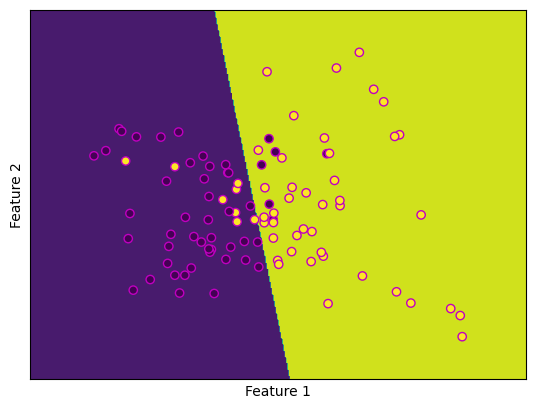

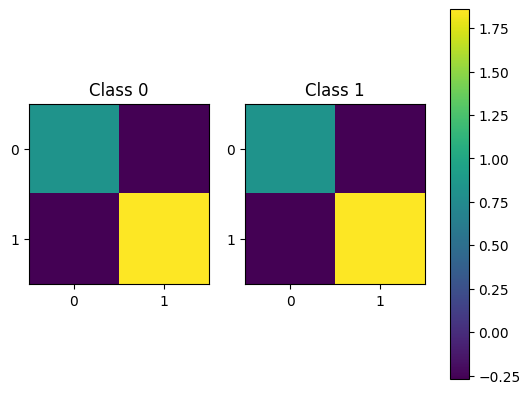

Точность классификатора shared на обучающей выборке: 0.84
Точность классификатора shared на тестовой выборке: 0.90


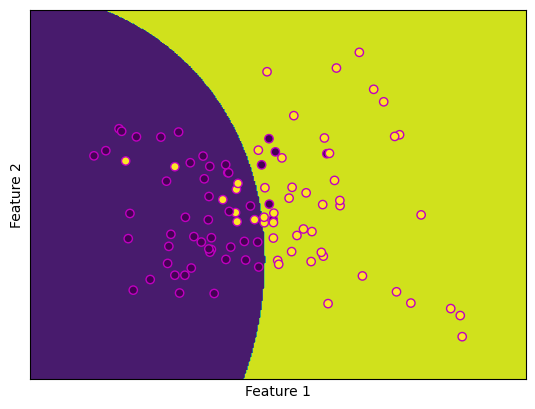

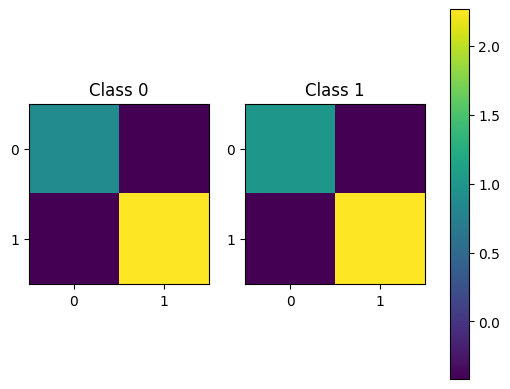

Точность классификатора no_assumption на обучающей выборке: 0.84
Точность классификатора no_assumption на тестовой выборке: 0.90


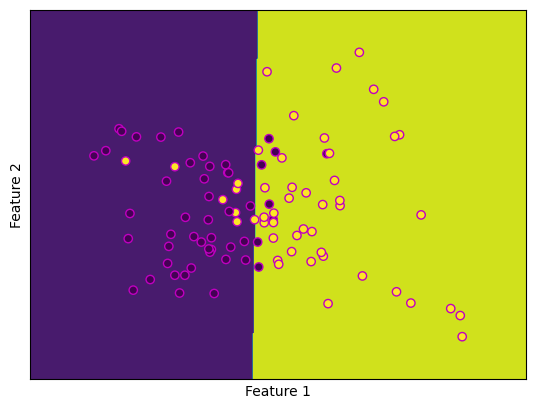

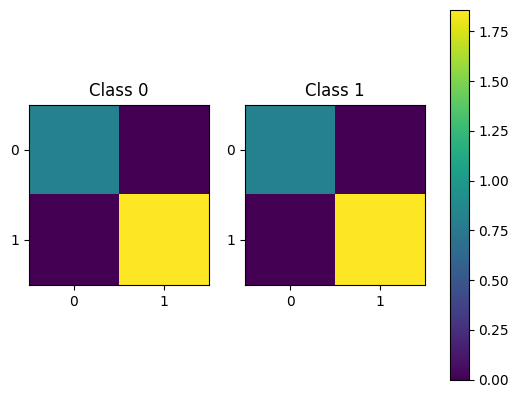

Точность классификатора shared_diag на обучающей выборке: 0.83
Точность классификатора shared_diag на тестовой выборке: 0.87


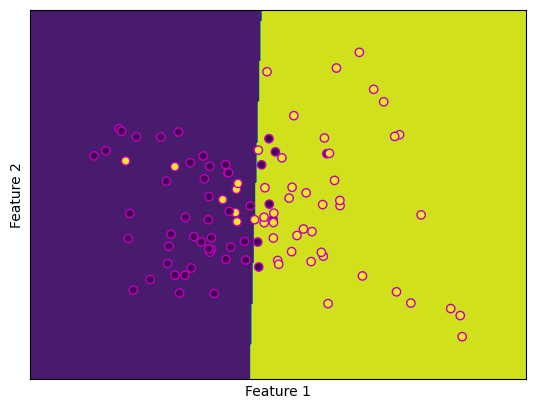

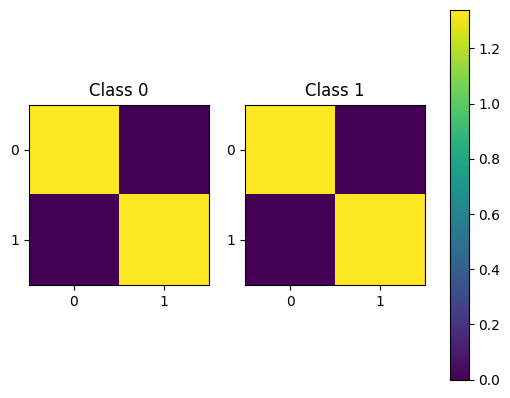

Точность классификатора shared_scalar на обучающей выборке: 0.83
Точность классификатора shared_scalar на тестовой выборке: 0.87


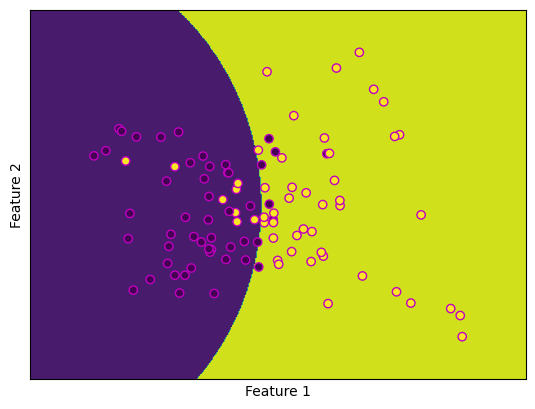

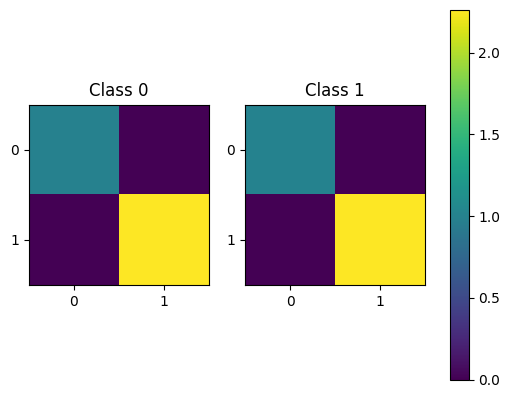

Точность классификатора diag на обучающей выборке: 0.83
Точность классификатора diag на тестовой выборке: 0.90


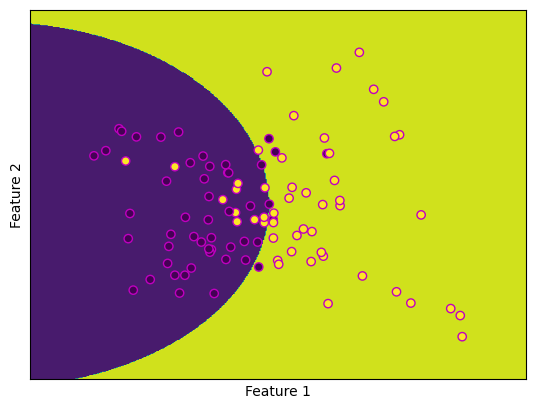

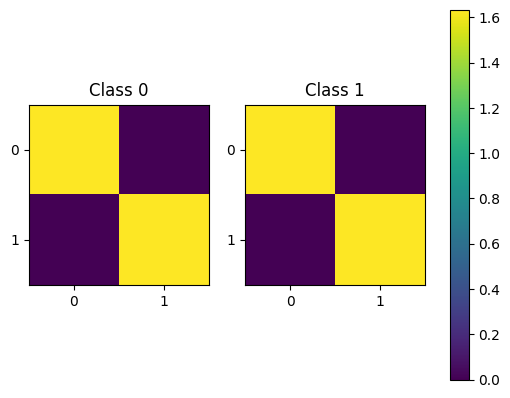

Точность классификатора scalar на обучающей выборке: 0.81
Точность классификатора scalar на тестовой выборке: 0.90


In [46]:
classifiers = [
     BayesClassifier(cov='shared'),
     BayesClassifier(cov='no_assumption'),
     BayesClassifier(cov='shared_diag'),
     BayesClassifier(cov='shared_scalar'),
     BayesClassifier(cov='diag'),
     BayesClassifier(cov='scalar')
]

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    plot_decision_boundary(clf, np.vstack((X_train, X_test)), np.hstack((y_train, y_test)))
    plot_cov_matrices(clf.params)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность классификатора {clf.cov} на обучающей выборке: {train_accuracy:.2f}")
    print(f"Точность классификатора {clf.cov} на тестовой выборке: {test_accuracy:.2f}")

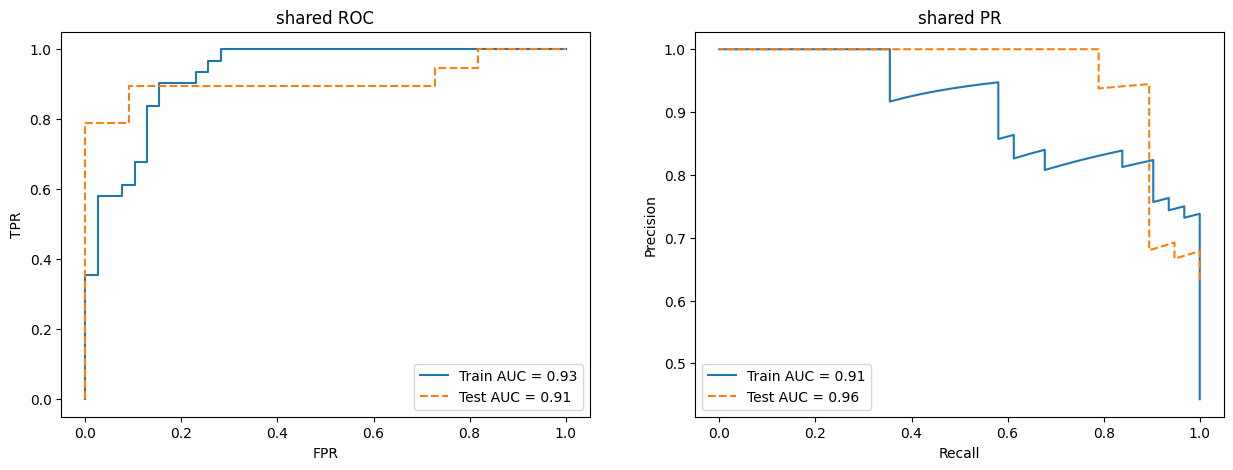

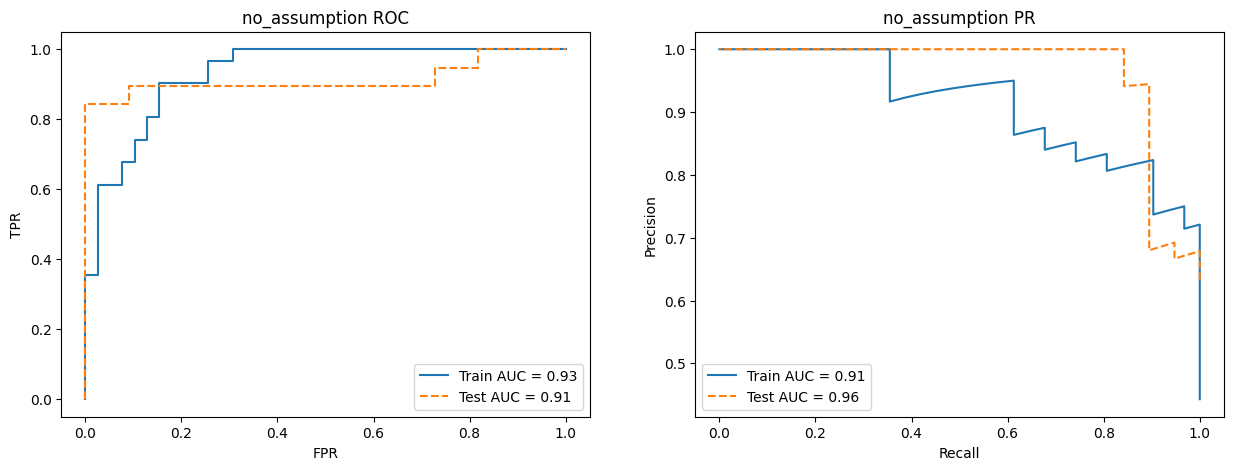

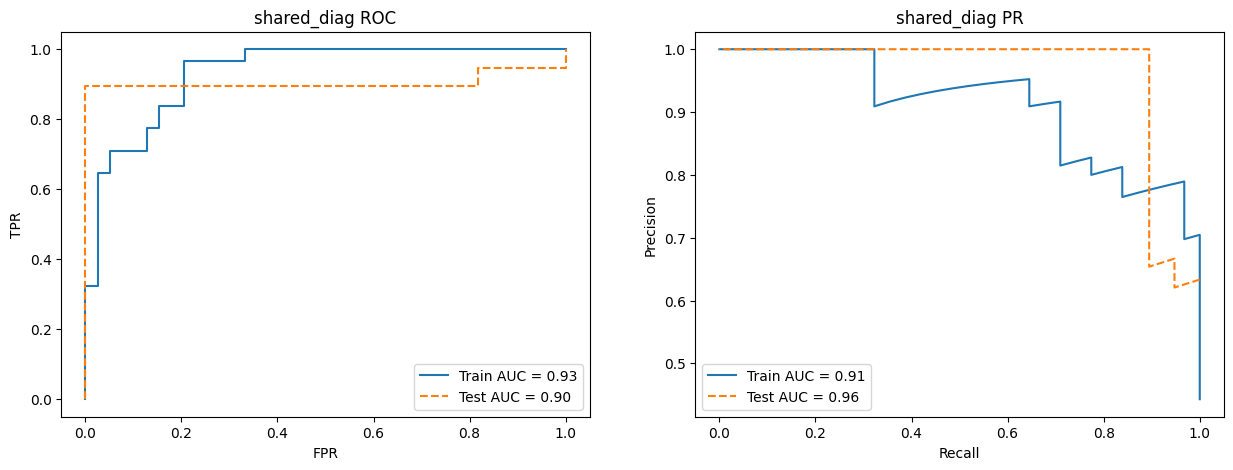

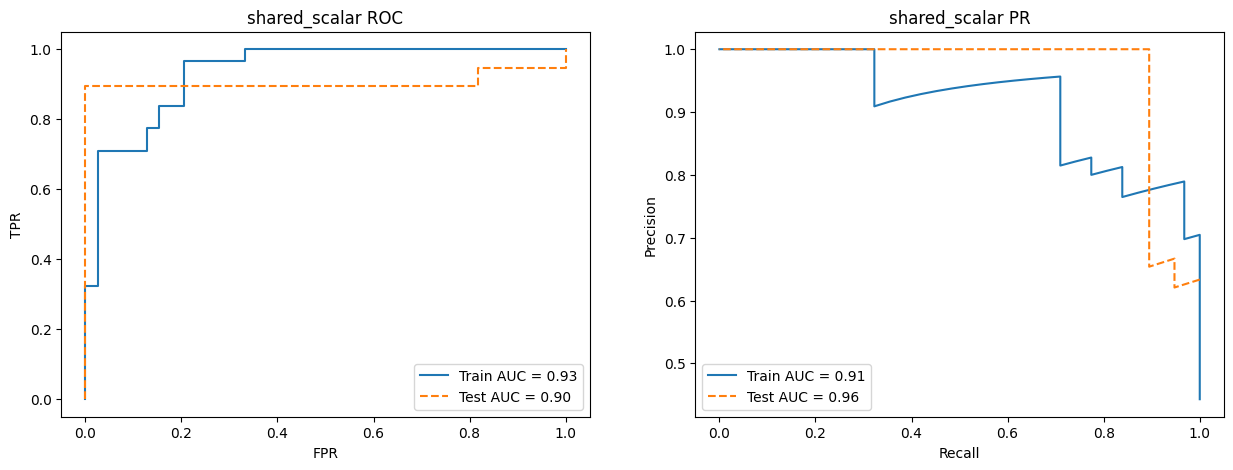

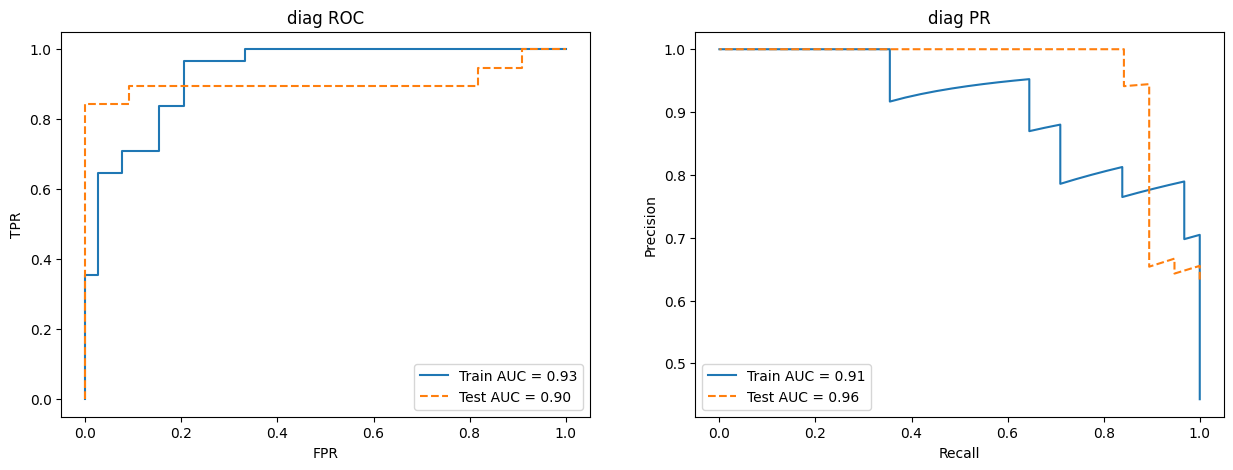

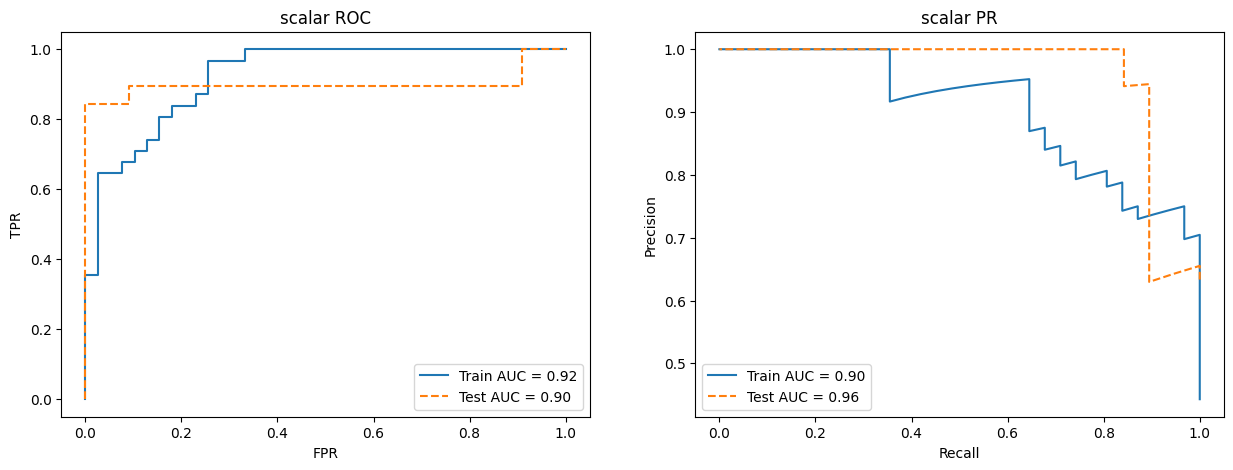

In [49]:
def plot_metrics(clf, X_train, y_train, X_test, y_test, title):
    y_score_train = clf.predict_proba(X_train)[:, 1]  
    y_score_test = clf.predict_proba(X_test)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
    pr_auc_train = auc(recall_train, precision_train)

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    pr_auc_test = auc(recall_test, precision_test)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {roc_auc_train:.2f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_test:.2f}', linestyle='--')
    plt.title(f'{title} ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(recall_train, precision_train, label=f'Train AUC = {pr_auc_train:.2f}')
    plt.plot(recall_test, precision_test, label=f'Test AUC = {pr_auc_test:.2f}', linestyle='--')
    plt.title(f'{title} PR')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

for clf in classifiers:
    plot_metrics(clf, X_train, y_train, X_test, y_test, clf.cov)

In [48]:
lrmodel = LogisticRegression()
lrmodel.fit(X_train, y_train)

labels_train_pred = lrmodel.predict(X_train)
labels_test_pred = lrmodel.predict(X_test)

print(f"Точность на обучающей выборке: {lrmodel.score(X_train, y_train)}")
print(f"Точность на тестовой выборке: {lrmodel.score(X_test, y_test)}")

Точность на обучающей выборке: 0.8428571428571429
Точность на тестовой выборке: 0.9
